# MNIST SHAP / LIME

## Introduction

The goal is to spit out some MNIST data into shap/lime, then try to hotwire some classes and see what happens. First though, we need an MNIST classifier, and this one from Amitrajit Bose seems to work just fine.

## Handwritten Digit Recognition
- Author = Amitrajit Bose
- Dataset = MNIST
- [Medium Article Link](https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- Frameworks = PyTorch


### Necessary Imports

In [1]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time

In [3]:
import os

### Download The Dataset & Define The Transforms

In [6]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('cache/mnist/', download=True, train=True, transform=transform)
valset = datasets.MNIST('cache/mnist/', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Exploring The Data

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


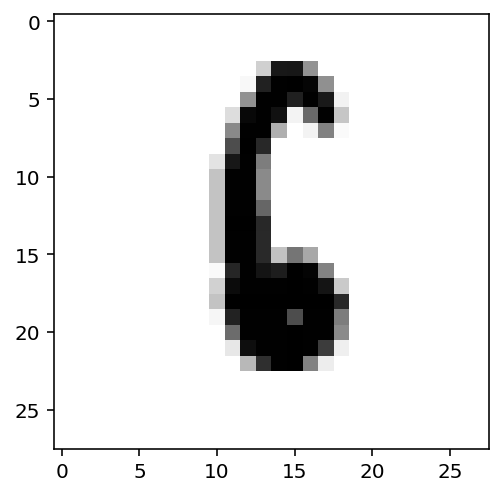

In [8]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfcAAAHwCAYAAAC7cCafAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAABYlAAAWJQFJUiTwAAAbz0lEQVR4nO3dfaxtZX0n8O+v0gilvChpS5pOA1gE0hede7EiZJCXVNG2Fip3NGmVtNq0HR3Fl6mTFiy0ncQ2k/peaauWBJOhBlMbLFUngl4otqaXKJJeBQoXpBV5G14EpAWf+WOvU29Pz7kve+9z1jnP/nySnXX2WuvZz+8uFud7nr3Xfla11gIA9OO7xi4AAJgv4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnTlg7ALWQlXdnuTQJLtGLgUApnVUkodba0fvb8Muwz3JoQcddNAzTzjhhGeOXQgATGPnzp15/PHHp2rba7jvOuGEE565Y8eOsesAgKls3bo1N9xww65p2o76mXtV/VBVfbiq/rmqnqiqXVX1rqp6xph1AcBmNtrIvaqeleT6JN+f5C+TfCXJTyZ5Y5KzquqU1tr9Y9UHAJvVmCP3P8ok2N/QWju7tfY/W2tnJHlnkuOS/K8RawOATWuUcB9G7S/K5Gr29y/b/NtJHk3yqqo6eJ1LA4BNb6y35U8flp9urX179w2ttUeq6m8yCf+TknxmtRepqtWumDt+LlUCwCY01tvyxw3Lm1fZfsuwfPY61AIAXRlr5H7YsHxole1L6w/f04u01rautH4Y0W+ZqjIA2ORMPwsAnRkr3JdG5oetsn1p/YNrXwoA9GWscP/qsFztM/Vjh+Vqn8kDAKsYK9yvGZYvqqp/V0NVHZLklCSPJfnb9S4MADa7UcK9tfaPST6dyR1vXrds88VJDk5yWWvt0XUuDQA2vTFvHPPfMpl+9j1VdWaSnUmen8l34G9O8lsj1gYAm9ZoV8sPo/cTk1yaSai/Jcmzkrw7yUnmlQeA6Yx6y9fW2teS/NKYNQBAb3zPHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDPCHQA6I9wBoDMHjF0AMJ4vfelLU7c966yzZuq7tTZT+wsuuGDqtq9//etn6hs2OiN3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzrjlK2xiTzzxxEztzznnnKnbfuMb35ip71lv+frmN7956rZPPfXUTH2/8Y1vnKk9rDUjdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojPu5wyb2J3/yJzO137Vr13wKmcJRRx01U/s77rhj6ra///u/P1Pfv/zLvzx120MOOWSmvmFfjDZyr6pdVdVWedw9Vl0AsNmNPXJ/KMm7Vlj/zXWuAwC6MXa4P9hau2jkGgCgKy6oA4DOjD1yf3pV/WKSH07yaJIbk2xvrT01blkAsHmNHe5HJrls2brbq+qXWmuf21vjqtqxyqbjZ64MADapMd+W/7MkZ2YS8Acn+fEkf5zkqCR/XVXPGa80ANi8Rhu5t9YuXrbqpiS/VlXfTPKWJBclOWcvr7F1pfXDiH7LHMoEgE1nI15Qd8mwPHXUKgBgk9qI4X7vsDx41CoAYJPaiOF+0rC8bdQqAGCTGiXcq+qEqvoPI/OqOirJ+4anH1nXogCgE2NdUPeKJG+pqu1J7kjySJJnJfnpJAcmuSrJ/x6pNgDY1MYK92uSHJfkPyc5JZPP1x9Mcl0m33u/rLXWRqoNADa1UcJ9mKBmr5PUwCK47bbpLy/5jd/4jTlWsn8OP/zwmdp/+ctfnqn9LP/2Sy65ZO877cFNN900ddsXvOAFM/UN+2IjXlAHAMxAuANAZ4Q7AHRGuANAZ4Q7AHRGuANAZ4Q7AHRGuANAZ4Q7AHRGuANAZ4Q7AHRGuANAZ4Q7AHRGuANAZ4Q7AHRmlPu5A99xxRVXTN32iSeemGMl++fDH/7wTO2/93u/d6b2f/AHfzB12yOPPHKmvk888cSZ2sNaM3IHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojFu+wsiuu+66qdu21mbq+/jjj5+67dlnnz1T37Oa5Zaxb3/72+dYCWw8Ru4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0Bn3c4cZ3XXXXTO1/8IXvjB126qaqe9t27bN1B7YmIzcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOuOWrzCjXbt2zdT+nnvumU8hUzjkkENG6xtYO0buANCZuYR7VZ1bVe+tqmur6uGqalX1kb20ObmqrqqqB6rq8aq6sarOr6qnzaMmAFhU83pb/oIkz0nyzSR3JTl+TztX1c8l+ViSbyX58yQPJPnZJO9MckqSbXOqCwAWzrzeln9TkmcnOTTJr+9px6o6NMmfJnkqyWmttde01v5Hkucm+XySc6vqlXOqCwAWzlzCvbV2TWvtltZa24fdz03yfUkub639/W6v8a1M3gFI9vIHAgCwujEuqDtjWH5yhW3bkzyW5OSqevr6lQQA/Rjjq3DHDcubl29orT1ZVbcn+dEkxyTZuacXqqodq2za42f+ANCzMUbuhw3Lh1bZvrT+8LUvBQD6s6knsWmtbV1p/TCi37LO5QDAhjDGyH1pZH7YKtuX1j+49qUAQH/GCPevDstnL99QVQckOTrJk0luW8+iAKAXY4T71cPyrBW2nZrke5Jc31p7Yv1KAoB+jBHuVyS5L8krq+rEpZVVdWCS3xuefmCEugCgC3O5oK6qzk5y9vD0yGH5gqq6dPj5vtbaW5OktfZwVf1KJiH/2aq6PJPpZ1+WydfkrshkSloAYArzulr+uUnOW7bumOGRJHckeevShtbax6vqhUl+K8nLkxyY5NYkb07ynn2c6Q4AWMFcwr21dlGSi/azzd8keek8+gcAvsP93AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADozr/u5A5vQrbfeOnYJwBowcgeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzgh3AOiMcAeAzrifO4ystTZa39u3bx+tb2DtGLkDQGeEOwB0RrgDQGeEOwB0RrgDQGeEOwB0RrgDQGeEOwB0RrgDQGeEOwB0RrgDQGeEOwB0RrgDQGeEOwB0xi1fYWRVtZB9A2vHyB0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOuN+7sBUrr322pnaX3nllTO137p169RtX/GKV8zUN2x0Ru4A0Jm5hHtVnVtV762qa6vq4apqVfWRVfY9ati+2uPyedQEAItqXm/LX5DkOUm+meSuJMfvQ5svJfn4CutvmlNNALCQ5hXub8ok1G9N8sIk1+xDmy+21i6aU/8AwGAu4d5a+7cwr6p5vCQAMKUxr5b/war61SRHJLk/yedbazfuzwtU1Y5VNu3LxwIA0KUxw/2nhse/qarPJjmvtXbnKBUBQAfGCPfHkvxuJhfT3Tas+4kkFyU5Pclnquq5rbVH9/ZCrbUVv+g6jOi3zKNYANhs1v177q21e1prb2+t3dBae3B4bE/yoiR/l+RHkrx2vesCgF5smElsWmtPJvng8PTUMWsBgM1sw4T74N5hefCoVQDAJrbRwv2kYXnbHvcCAFa17uFeVVuq6j/0W1VnZjIZTpKsOHUtALB3c7lavqrOTnL28PTIYfmCqrp0+Pm+1tpbh5//MMmxVXV9JrPaJZOr5c8Yfr6wtXb9POoCgEU0r6/CPTfJecvWHTM8kuSOJEvhflmSc5I8L8lLknx3km8k+WiS97XWZruPJAAsuHlNP3tRJt9T35d9P5TkQ/PoFzaC5z//+TO1P/bYY6due8stt8zU97333rv3nVbxC7/wCzP1/bWvfW2m9gccMP2vr5tvvnmmvi+88MKZ2sNa22gX1AEAMxLuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANAZ4Q4AnRHuANCZed3PHRbWzp07Z2r/T//0T3OqZP/df//9o/U9q6eeemrqtu95z3tm6vuss86auu3znve8mfqGfWHkDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdcT93mNHDDz88U/tHH310TpUsltba1G3vu+++mfp+9atfPXXbnTt3ztQ37AsjdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM645SvMaOvWrTO1P+aYY6Zue/vtt8/U95h+5md+Zqb2n/jEJ+ZUyf7btm3baH3DvjByB4DOCHcA6IxwB4DOCHcA6IxwB4DOCHcA6IxwB4DOCHcA6IxwB4DOCHcA6IxwB4DOCHcA6IxwB4DOCHcA6IxwB4DOuJ87zOiggw6aqf1LX/rSqdu+//3vn6nvMV155ZUzta+qOVWy/w455JDR+oZ9MfPIvaqOqKrXVtVfVNWtVfV4VT1UVddV1WuqasU+qurkqrqqqh4Y2txYVedX1dNmrQkAFtk8Ru7bknwgydeTXJPkziQ/kOTnk3wwyUuqaltrrS01qKqfS/KxJN9K8udJHkjys0nemeSU4TUBgCnMI9xvTvKyJH/VWvv20sqq+s0kX0jy8kyC/mPD+kOT/GmSp5Kc1lr7+2H9hUmuTnJuVb2ytXb5HGoDgIUz89vyrbWrW2tX7h7sw/q7k1wyPD1tt03nJvm+JJcvBfuw/7eSXDA8/fVZ6wKARbXWV8v/67B8crd1ZwzLT66w//YkjyU5uaqevpaFAUCv1uxq+ao6IMmrh6e7B/lxw/Lm5W1aa09W1e1JfjTJMUl27qWPHatsOn7/qgWAfqzlyP0dSX4syVWttU/ttv6wYfnQKu2W1h++RnUBQNfWZOReVW9I8pYkX0nyqrXoI0laa1tX6X9Hki1r1S8AbGRzH7lX1euTvDvJPyQ5vbX2wLJdlkbmh2VlS+sfnHdtALAI5hruVXV+kvcmuSmTYL97hd2+OiyfvUL7A5IcnckFeLfNszYAWBRzC/eqelsmk9B8MZNgv2eVXa8elmetsO3UJN+T5PrW2hPzqg0AFslcwn2YgOYdSXYkObO1dt8edr8iyX1JXllVJ+72Ggcm+b3h6QfmURcALKKZL6irqvOS/E4mM85dm+QNK9zQYVdr7dIkaa09XFW/kknIf7aqLs9k+tmXZfI1uSsymZIWAJjCPK6WP3pYPi3J+avs87kkly49aa19vKpemOS3Mpme9sAktyZ5c5L37D4PPQCwf6rHHK2qHVu2bNmyY8dqc9zAxnH33Stdd7pvjjvuuL3vtAePPPLITO1nMevvnllu+XrKKafM1Pcst6s9/PDDZ+qbxbF169bccMMNN6z2te89WevpZwGAdSbcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOnPA2AXAojvyyCOnbvvRj350pr7f9ra3Td32xhtvnKnvWV188cVTt33d6143U9/uyc5GZ+QOAJ0R7gDQGeEOAJ0R7gDQGeEOAJ0R7gDQGeEOAJ0R7gDQGeEOAJ0R7gDQGeEOAJ0R7gDQGeEOAJ0R7gDQGbd8hU3sxS9+8ajtgY3JyB0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzwh0AOiPcAaAzM4d7VR1RVa+tqr+oqlur6vGqeqiqrquq11TVdy3b/6iqant4XD5rTQCwyA6Yw2tsS/KBJF9Pck2SO5P8QJKfT/LBJC+pqm2ttbas3ZeSfHyF17tpDjUBwMKaR7jfnORlSf6qtfbtpZVV9ZtJvpDk5ZkE/ceWtftia+2iOfQPAOxm5rflW2tXt9au3D3Yh/V3J7lkeHrarP0AAPtmHiP3PfnXYfnkCtt+sKp+NckRSe5P8vnW2o1rXA8AdG/Nwr2qDkjy6uHpJ1fY5aeGx+5tPpvkvNbanfvYx45VNh2/j2UCQHfW8qtw70jyY0muaq19arf1jyX53SRbkzxjeLwwk4vxTkvymao6eA3rAoCurcnIvarekOQtSb6S5FW7b2ut3ZPk7cuabK+qFyW5Lsnzk7w2ybv31k9rbesq/e9IsmX/KweAzW/uI/eqen0mwfwPSU5vrT2wL+1aa09m8tW5JDl13nUBwKKYa7hX1flJ3pvJd9VPH66Y3x/3DktvywPAlOYW7lX1tiTvTPLFTIL9nile5qRhedu86gKARTOXcK+qCzO5gG5HkjNba/ftYd8ty6ekHdafmeRNw9OPzKMuAFhEM19QV1XnJfmdJE8luTbJG6pq+W67WmuXDj//YZJjq+r6JHcN634iyRnDzxe21q6ftS4AWFTzuFr+6GH5tCTnr7LP55JcOvx8WZJzkjwvyUuSfHeSbyT5aJL3tdaunUNNALCwZg73YX74i/Zj/w8l+dCs/QIAK3M/dwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDojHAHgM4IdwDoTLXWxq5h7qrq/oMOOuiZJ5xwwtilAMBUdu7cmccff/yB1toR+9u213C/PcmhSXatssvxw/Ir61JQHxyz6Thu03Hc9p9jNp2NfNyOSvJwa+3o/W3YZbjvTVXtSJLW2taxa9ksHLPpOG7Tcdz2n2M2nV6Pm8/cAaAzwh0AOiPcAaAzwh0AOiPcAaAzC3m1PAD0zMgdADoj3AGgM8IdADoj3AGgM8IdADoj3AGgM8IdADqzUOFeVT9UVR+uqn+uqieqaldVvauqnjF2bRvVcIzaKo+7x65vLFV1blW9t6quraqHh+Pxkb20ObmqrqqqB6rq8aq6sarOr6qnrVfdY9uf41ZVR+3h3GtVdfl61z+Gqjqiql5bVX9RVbcO585DVXVdVb2mqlb8Pb7o59v+HrfezrcDxi5gvVTVs5Jcn+T7k/xlJvfu/ckkb0xyVlWd0lq7f8QSN7KHkrxrhfXfXOc6NpILkjwnk2NwV75zT+gVVdXPJflYkm8l+fMkDyT52STvTHJKkm1rWewGsl/HbfClJB9fYf1N8ytrQ9uW5ANJvp7kmiR3JvmBJD+f5INJXlJV29puM5I535JMcdwGfZxvrbWFeCT5VJKW5L8vW/+Hw/pLxq5xIz6S7Eqya+w6NtojyelJjk1SSU4bzqGPrLLvoUnuSfJEkhN3W39gJn9wtiSvHPvftAGP21HD9kvHrnvkY3ZGJsH8XcvWH5lJYLUkL99tvfNtuuPW1fm2EG/LD6P2F2USVO9ftvm3kzya5FVVdfA6l8Ym1Vq7prV2Sxt+K+zFuUm+L8nlrbW/3+01vpXJSDZJfn0Nytxw9vO4kaS1dnVr7crW2reXrb87ySXD09N22+R8y1THrSuL8rb86cPy0yv8h36kqv4mk/A/Kcln1ru4TeDpVfWLSX44kz+EbkyyvbX21LhlbRpnDMtPrrBte5LHkpxcVU9vrT2xfmVtGj9YVb+a5Igk9yf5fGvtxpFr2ij+dVg+uds659verXTclnRxvi1KuB83LG9eZfstmYT7syPcV3JkksuWrbu9qn6ptfa5MQraZFY9/1prT1bV7Ul+NMkxSXauZ2GbxE8Nj39TVZ9Ncl5r7c5RKtoAquqAJK8enu4e5M63PdjDcVvSxfm2EG/LJzlsWD60yval9YevfSmbzp8lOTOTgD84yY8n+eNMPp/666p6znilbRrOv+k8luR3k2xN8ozh8cJMLo46LclnFvyjtHck+bEkV7XWPrXbeufbnq123Lo63xYl3JlSa+3i4bOrb7TWHmut3dRa+7VMLkQ8KMlF41ZIr1pr97TW3t5au6G19uDw2J7Ju2x/l+RHkrx23CrHUVVvSPKWTL7186qRy9k09nTcejvfFiXcl/5SPWyV7UvrH1z7UrqxdEHKqaNWsTk4/+aotfZkJl9lShbw/Kuq1yd5d5J/SHJ6a+2BZbs431awD8dtRZv1fFuUcP/qsHz2KtuPHZarfSbPf3TvsNw0b1ONaNXzb/j87+hMLuy5bT2L2uQW8vyrqvOTvDeT71yfPlz5vZzzbZl9PG57sunOt0UJ92uG5YtWmJXokEwmdXgsyd+ud2Gb2EnDcmF+Qczg6mF51grbTk3yPUmuX+Arl6excOdfVb0tk0lovphJQN2zyq7Ot93sx3Hbk013vi1EuLfW/jHJpzO5COx1yzZfnMlfY5e11h5d59I2tKo6YaULSKrqqCTvG57uccpVkiRXJLkvySur6sSllVV1YJLfG55+YIzCNrKq2rLS1KpVdWaSNw1PF+L8q6oLM7kQbEeSM1tr9+1hd+fbYH+OW2/nWy3KXBIrTD+7M8nzM/kO/M1JTm6mn/13quqiTC4+2Z7kjiSPJHlWkp/OZLarq5Kc01r7l7FqHEtVnZ3k7OHpkUlenMlf9dcO6+5rrb112f5XZDId6OWZTAf6sky+tnRFkv+6CBO77M9xG75+dGwm/9/eNWz/iXzne9wXttaWwqpbVXVekkuTPJXJW8srXQW/q7V26W5tzs6Cn2/7e9y6O9/GniJvPR9J/lMmX+36epJ/ySSw3pXkGWPXthEfmXwN5P9kcmXpg5lM/HBvkv+byfdEa+waRzw2F2UyVeVqj10rtDklkz+I/l+Sx5N8OZMRwdPG/vdsxOOW5DVJPpHJzJLfzGQ61TszmSv9v4z9b9lAx6wl+azzbbbj1tv5tjAjdwBYFAvxmTsALBLhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0BnhDgCdEe4A0Jn/D3Y4gATPgDdrAAAAAElFTkSuQmCC

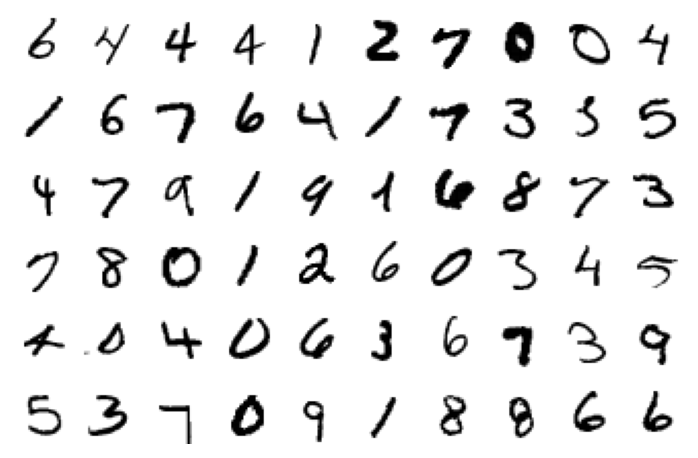

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [10]:
from torch import nn

# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [11]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [12]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0.0031, 0.0031, 0.0031,  ..., 0.0031, 0.0031, 0.0031],
        [0.0015, 0.0015, 0.0015,  ..., 0.0015, 0.0015, 0.0015],
        [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
        ...,
        [0.0011, 0.0011, 0.0011,  ..., 0.0011, 0.0011, 0.0011],
        [0.0006, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
        [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0036]])


In [13]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [14]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0304, -0.0354,  0.0199,  ...,  0.0287,  0.0312, -0.0183],
        [-0.0136,  0.0034, -0.0068,  ..., -0.0007,  0.0029, -0.0058],
        [-0.0089, -0.0075,  0.0106,  ..., -0.0057,  0.0165,  0.0197],
        ...,
        [-0.0120,  0.0138, -0.0058,  ..., -0.0052,  0.0253,  0.0302],
        [ 0.0310, -0.0118, -0.0071,  ...,  0.0106,  0.0044,  0.0076],
        [-0.0138,  0.0174, -0.0314,  ...,  0.0033, -0.0131,  0.0140]],
       requires_grad=True)
Gradient - tensor([[-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [ 0.0044,  0.0044,  0.0044,  ...,  0.0044,  0.0044,  0.0044],
        [ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        ...,
        [ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0049,  0.0049,  0.0049,  ...,  0.0049,  0.0049,  0.0049],
        [ 0.0057,  0.0057,  0.0057,  ...,  0.0057,  0.0057,  0.0057]])


In [12]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0196, -0.0303, -0.0086,  ...,  0.0089,  0.0172,  0.0182],
        [-0.0005, -0.0335, -0.0071,  ...,  0.0088, -0.0111, -0.0042],
        [ 0.0294,  0.0251, -0.0254,  ...,  0.0180,  0.0154,  0.0208],
        ...,
        [ 0.0123, -0.0224,  0.0345,  ..., -0.0333, -0.0319,  0.0336],
        [-0.0163, -0.0323,  0.0203,  ...,  0.0213, -0.0320, -0.0273],
        [-0.0333, -0.0258,  0.0035,  ..., -0.0330, -0.0142,  0.0266]],
       requires_grad=True)


### Core Training Of Neural Network

In [15]:
from tqdm.notebook import tqdm

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in tqdm(range(epochs)):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0 - Training loss: 0.635678924056195
Epoch 1 - Training loss: 0.28107289548145176
Epoch 2 - Training loss: 0.21658369929376822
Epoch 3 - Training loss: 0.17296503489014944
Epoch 4 - Training loss: 0.1429452044345232
Epoch 5 - Training loss: 0.12404495841964508
Epoch 6 - Training loss: 0.10876425461017533
Epoch 7 - Training loss: 0.09577472410254133
Epoch 8 - Training loss: 0.08637810495993825
Epoch 9 - Training loss: 0.0779154965324379
Epoch 10 - Training loss: 0.07170333501859022
Epoch 11 - Training loss: 0.06556532188439801
Epoch 12 - Training loss: 0.06041640534933442
Epoch 13 - Training loss: 0.05528915814830979
Epoch 14 - Training loss: 0.05106422986670423

Training Time (in minutes) = 2.1484143296877543


In [16]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 7


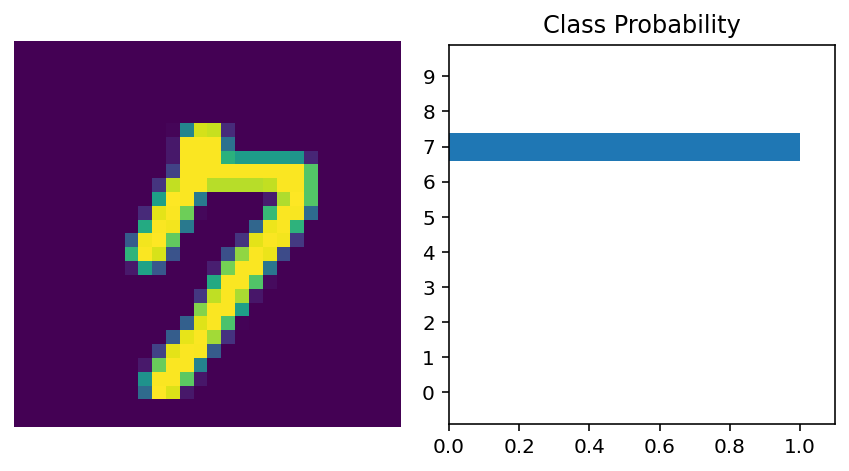

In [17]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation

In [18]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9763
